# Developing Machine Learning Apps for Healthcare

In [ ]:
#@title Run this to prepare our libraries and data! { display-mode: "form" } 

# networking
!pip -q install pyngrok
!pip -q install streamlit
!pip -q install patool

import cv2
import gdown
import glob
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import patoolib

from joblib import dump
from pyngrok import ngrok
from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

DATA_ROOT = '/content'
os.makedirs(DATA_ROOT, exist_ok=True)
max_samples = 3000

blood_slide_url = 'https://drive.google.com/uc?id=1lffxAG8gykh1dh1pCP34uRkH3XMwuNt-'
blood_slide_path = os.path.join(DATA_ROOT, 'blood_slide.jpg')
gdown.download(blood_slide_url, blood_slide_path, True)

!wget "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/malaria_images.zip"
!unzip "malaria_images.zip"
malaria_imgs_path = os.path.join(DATA_ROOT, 'malaria_images.zip')

print("Downloaded Data")

u_malaria_img_paths = glob.glob('/content/malaria_images/Uninfected/*png')
p_malaria_img_paths = glob.glob('/content/malaria_images/Parasitized/*png')

NUM_SAMPLES = len(u_malaria_img_paths) + len(p_malaria_img_paths)

X = []
y = []

X_g = []

for i in tqdm(range(max_samples)):
  img = cv2.imread(u_malaria_img_paths[i])
  X.append(cv2.resize(img,(50,50)))

  gray_img = cv2.imread(u_malaria_img_paths[i],0)
  X_g.append(cv2.resize(gray_img,(50,50)))

  y.append(0)

for i in tqdm(range(max_samples)):
  img = cv2.imread(p_malaria_img_paths[i])
  X.append(cv2.resize(img,(50,50)))

  gray_img = cv2.imread(p_malaria_img_paths[i],0)
  X_g.append(cv2.resize(gray_img,(50,50)))

  y.append(1)

X = np.stack(X)
X_g = np.stack(X_g)
X_reshaped = np.reshape(X_g,(X_g.shape[0],2500))

y = np.array(y)

blood_samples_dir = 'blood_samples'
if (os.path.exists(blood_samples_dir) == False):
  os.mkdir(blood_samples_dir)

for i, img in enumerate(X[2995:3005]):
  plt.imsave('test_img_{}.jpg'.format(i), img)
  
print("Created our X and y variables")


Streaming output truncated to the last 5000 lines.
  inflating: malaria_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
  inflating: malaria_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
  inflating: malaria_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
  inflating: malaria_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
  inflating: malaria_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
  inflating: malaria_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
  inflating: malaria_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
  inflating: malaria_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
  inflating: malaria_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_222.png  
  inflating: malaria_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_87.png  
  inflating: malaria_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_91.png  
  inflating: malaria_images

100%|██████████| 3000/3000 [00:03<00:00, 954.44it/s]


Created our X and y variables


In this notebook, we'll build a machine learning model to diagnose malaria and deploy our model to a mobile-friendly web app. 

**Discuss: Why is it important to deploy AI models to apps, especially in healthcare? Who could benefit?**

One huge benefit is that machine learning apps can quickly and cheaply screen people for diseases! Check out a few examples:
*  [Detecting early Parkinson's disease](https://parkinsonsnewstoday.com/2019/01/15/smartphone-app-identifies-early-symptoms-motor-disorders-study/) by analyzing finger-tapping
*  [Recognizing asymptomatic COVID-19](https://news.mit.edu/2020/covid-19-cough-cellphone-detection-1029) based on particular cough sounds
*  (Developed by a high-schooler!) [Screening for eye disease with computer vision](https://www.youtube.com/watch?v=kLx4ey4d8DQ) in parts of the world where there aren't enough doctors 

Because billions of people worldwide have smartphones, ML apps have the potential to get huge numbers of people diagnosed and treated!

Today, we'll build an app to help fight one of the world's most terrible diseases: malaria, which every year infects over 200 million people and kills more than 200,000 children. Our goal is to help healthcare workers in rural or developing areas diagnose malaria without expensive lab equipment. Our app will let a healthcare worker upload an image of blood cells under a microscope, and then use computer vision to detect the malaria parasite.

![](https://cdn1.sph.harvard.edu/wp-content/uploads/sites/21/2018/01/parasite.jpg)

We'll split our work into three parts:
*   Back-end: building a machine learning model to classify an image of blood cells 
*   Front end: making an easy-to-use, mobile-friendly website that lets users upload an image and outputs the answer
*   Connecting the front-end and back-end so the model can analyze the user's image

# Part 1: Malaria Diagnosis

Let's construct a machine learning model to diagnose malaria!

**Exercise**: To start off, let's explore our data. Our images of blood cells are stored in `X`, and our corresponding labels (1 = Malaria, 0 = No Malaria) are stored in `y`.
 * Print out the `shape` of both `X` and `y`.
 * Use `plt.imshow` to display one of the images in `X`.
 * Print out the corresponding label in `y`.



In [ ]:
# YOUR CODE HERE
X.shape
y.shape

(6000,)

malaria


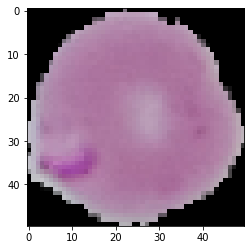

In [ ]:
img = 5025
plt.imshow(X[img])
if y[img] == 0: 
  print('no malaria')
else:
  print('malaria')

Next, let's try to visualize our entire dataset. It's tricky with high-dimensional data, but we can use a mathematical technique called Principal Component Analysis (PCA) to visualize it in 2D.

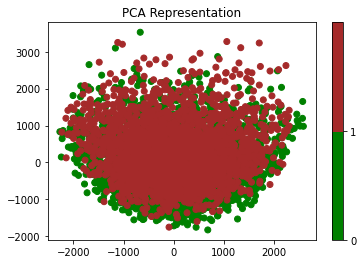

In [ ]:
#@title Run this to perform and visualize PCA! { display-mode: "form" } 
pca = PCA(n_components=20)

X_pca = pca.fit_transform(X_reshaped)

colors = ["green","brown"]
classes = [0,1]

plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap=matplotlib.colors.ListedColormap(colors))
cb = plt.colorbar()
loc = np.arange(0,max(y),max(y)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels(classes)
plt.title("PCA Representation")
plt.show()

**Discuss: What do you notice here? Does it look like it'll be easy to distinguish positive and negative examples?**

#Training Our Model

Fingers crossed - let's train our ML model!

**Exercise**: First, you should perform a `train_test_split`. Pass in `X_reshaped` and `y`. You should use a test size of 0.33.

In [ ]:
# Your Code Here
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.33, random_state=1)

In [ ]:
#X_train.shape
X_test.shape

(1980, 2500)

**Exercise**: Next, you should train an `SVC` model using the `fit` function. (An SVC is a Support Vector Machine classifier: this is a common though mathematically tricky algorithm.)

In [ ]:
model = SVC()
# Your Code Here
model.fit(X_train, y_train)

SVC()

**Exercise**: Finally, you should calculate the accuracy of your model using the `score` function. Print out your model's accuracy.

In [ ]:
# Your Code Here
model.score(X_test, y_test)

0.6656565656565656

In [ ]:
y_test.mean()

0.48434343434343435

Nice - we've developed a machine learning method for identifying parasitized blood cells to help diagnose malaria! Of course, you can always come back later to make your model more accurate.

For now, let's save our model to a file so we can use it in a web app.

In [ ]:
dump(model, "model.joblib")

['model.joblib']

# Part 2: Creating a Healthcare App User Interface

Now, let's make a user interface for our malaria diagnosis app.

**Discuss: What elements should our web app include to be effective and easy to use?**

We'll build our app using [Streamlit](https://www.streamlit.io/), a new Python package designed for quickly building machine-learning web apps. This means we'll be able to write all our code right here in Colab - much easier than using classic web design tools like HTML and JavaScript!

We'll use a nifty Colab command, `%%writefile`, to write code directly to a Python file: `app.py`. To start with, let's create a super-basic web app with just a title.

In [ ]:
%%writefile app.py
import streamlit as st
from joblib import load
import numpy as np
import cv2

model = load("model.joblib")

st.title('Malaria Prediction') #Change the title here!

uploaded_file = st.file_uploader("Upload File")

if uploaded_file is not None:
  st.image(uploaded_file, caption='Your Image')

  file_bytes = np.asarray(bytearray(uploaded_file.read()), dtype=np.uint8)
  image = cv2.imdecode(file_bytes, 1)

  small = cv2.resize(image, (50,50)) #YOUR CODE HERE: specify image, dimensions
  gray = cv2.cvtColor(small, cv2.COLOR_BGR2GRAY)

  gray_flat = np.reshape(gray,(1,2500))
  prediction = model.predict(gray_flat)[0]

  if prediction == 1:
    st.write('This is Malaria')
  else:
    st.write("This is not Malaria.")

#Later: add more Streamlit code here

Overwriting app.py


Now, in three lines of code we can host our app on the Web! But first, we need to quickly set up an ngrok account.
1. First, run the cell below titled "Publish Web App", then click the URL to access (what will be) your webpage.
2. Initially, you should see a webpage titled "Welcome to ngrok!". You should see a button labeled "Sign up for an ngrok account." Go ahead and press this button to make an account.
3. Once you have made an account, go to this link: https://dashboard.ngrok.com/get-started/your-authtoken. Press the "Copy" button next to the auth token to copy it to your clipboard.
4. Replace the YOUR_AUTH_TOKEN_HERE with your auth token in the code cell titled "Set up your auth token".
5. Stop running the cell titled "Publish Web App." Next, run the code cell with your auth token to set up your auth token with ngrok.
6. Re-run the cell titled "Publish Web App." to view your webpage!

In [ ]:
# Publish Web App (Run this again whenever you make changes)
public_url = ngrok.connect(port='80')
print (public_url)
!streamlit run --server.port 80 app.py >/dev/null

NgrokTunnel: "http://a699-34-126-142-71.ngrok.io" -> "http://localhost:80"
2022-05-28 02:56:00.699 INFO    numexpr.utils: NumExpr defaulting to 2 threads.


In [ ]:
# Set up your auth token
!ngrok authtoken '29m4prVlDfEImYxgDwtvfaubmN8_5owRMCNP1D96HS3KbDJ4W'

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


**Note**: You might run into odd errors sometimes when you publish your web app. If you run into odd errors at any time, follow these steps:

1.   Press the spinning circle to the left of the "Publish Web App" code cell to stop publishing the web app.
2.   Run the below code cell to reinitialize Streamlit.
3.   Re-run your code cell containing your `%%writefile app.py`.
4.   Re-run the "Publish Web App" code cell to publish your web app again.





In [ ]:
#@title If you get an error above, run this cell to reinitialize Streamlit, then try again!
%%writefile ~/.streamlit/config.toml
[server]
port = 80

Writing /root/.streamlit/config.toml


FileNotFoundError: ignored

Now, you can customize your Streamlit user interface (UI)! 

Choose the elements you want from the toolbox below, then copy-paste them into the `%%writefile app.py` code above in whatever order you'd like to define your UI. If you want, you can check out this [cheat sheet](https://share.streamlit.io/daniellewisdl/streamlit-cheat-sheet/app.py) for more Streamlit features.


In [ ]:
#Your Streamlit Toolbox!

"""
#Text
st.write("text")

#Title
st.title('title')

#Header
st.header('header')

#Slider
value = st.slider('variable')

#Table
st.table(dataframe) # Replace with your own Pandas dataframe variable

#Matplotlib Figure
st.pyplot(fig) # Replace with your own Matplotlib figure variable

#Image
st.image(image, caption='Image Caption') # Replace with your own image variable

#Button
pressed = st.button('Button Name')

#Checkbox
checked = st.checkbox('Checkbox Name')

#File Input
uploaded_file = st.file_uploader("Upload File")

if uploaded_file is not None:    
    pass #Do something here!

"""

Now take these Streamlit elements and design your interface for malaria diagnosis! Be sure to replace any placeholder values and variable names with your specifics in mind.

#Part 3: Connecting Our App and Model
Now we've got a beautiful web app, but it can't do anything yet! Let's connect our app to our model, so that the user can upload an image of a blood slide, the model will analyze the image, and finally the app will display the diagnosis result with some text. 

We'll start off by writing our image processing code here in Colab. Although it won't execute here, it'll be easier to visualize the steps. Later, we'll add it to our Streamlit code.

First things first: we need to check if an image has been uploaded! **What code from your Streamlit Toolbox will make sure that we only start analyzing an image once it's uploaded?**



In [ ]:
#Your Code Here
uploaded_file = st.file_uploader("Upload File")

NameError: ignored

Once we get an image, we'll convert it to a Numpy array like this:

In [ ]:
#Remember, this won't run here!
file_bytes = np.asarray(bytearray(uploaded_file.read()), dtype=np.uint8)
image = cv2.imdecode(file_bytes, 1)

NameError: ignored

Next, we'll convert `image` into a 50 x 50 grayscale image: we'll convert it to grayscale and then to the new dimensions. Please complete the code:


In [ ]:
small = cv2.resize(image, (50,50)) #YOUR CODE HERE: specify image, dimensions
gray = cv2.cvtColor(small, cv2.COLOR_BGR2GRAY)

Next up, you'll use the `np.reshape()` function to flatten our image into a 1x2500 array and `model.predict()` to classify it.

In [ ]:
#Your Code Here
gray_flat = np.reshape(gray,(1,2500))
prediction = model.predict(gray_flat)[0]

NameError: ignored

Based on the predicted output, you'll write a message to the user to tell them their results! You can write text with  `st.write()`.

In [ ]:
#Your Code Here
if prediction == 1:
  st.write('This is Malaria')
else:
  st.write("This is not Malaria.")

Excellent - now we're ready! Please paste the code above into your Streamlit code in the right order, and check out your finished website!

If you want images to test it out on, you can download 5 non-malaria and 5 malaria images from the Files tab on the left-hand side. 

#Discussion: Ethics
Now you know how to quickly deploy an ML model, and you can share any models you build using Streamlit web apps! You can also deploy your apps permanently using solutions like Heroku.

But especially in healthcare, it's not always clear that deploying a machine learning app is ethically the right thing to do. **Discuss:**


*   How could your app help people? How could you get people to use your app?
*   What could go wrong if your app makes mistakes, or if people use your app instead of consulting an expert?
*   How confident must you be in your app's accuracy before you deploy it? How can you make sure your app works well for different people in different circumstances? 
*   What information should you include on your page so users can make good decisions about using your app?

